## GENEROWANIE NAJKRÓTSZYCH TRAS

W celu obliczenia najkrótszej trasy możliwej do pokonania przez pojazd, poruszający się po zadanym zakręcie, skorzystamy z funkcji generującej 1000 losowych zakrętów. Jest ona złożona z pętli, która przechodzi po kolejnych elementach, losowowo wygenerowanych tablic, zmiennych mieszczących się w zadeklarowanym przedziale. Tutaj ze względu na ogarniczenia, aby żadna wygenerowana droga nie wychodziła poza trasę, eliminujemy trasy które nie mieszczą się w ograniczeniach (ograniczenie_g oraz ograniczenie_d).

In [44]:
using Distributions
using Plots
using QuadGK
using ForwardDiff
using DataFrames

ograniczenie_d = 10 # promien krótszego łuku
ograniczenie_g = 20 # promien dluzszego luku
punktp_sx = 15 # z tego punktu start (x = 15)
punktp_sy = 0 # z tego punktu start (y =0)

# Tworzenie trasy
f(x) = ograniczenie_g*sin(x)
g(x) = ograniczenie_g*cos(x)
h(x) = ograniczenie_d*sin(x)
j(x) = ograniczenie_d*cos(x)
tab1 = [g, j]
tab2 = [f, h]

tab3 = Array{Function}(undef, 0)
tab4 = Array{Function}(undef, 0)
tab_dlugosci_luku = []
tab_dlugosci_luku_2 = []
x3 = []
y = []
r = []
al = []
dl = []
k = rand(Uniform(-300, 0), 1000) # 1000 przypadkowych wartości z przedziału
c = rand(Uniform(-300, 300), 1000)

for t1 in k
    for t2 in c
        x2 = t1
        y3 = x2 + t2
        r1 = sqrt((x2-punktp_sx)^2 + (y3)^2) # promien danego okregu
        odl = sqrt((x2)^2 + (y3)^2) # odl miedzy punktem (0,0), a srodkiem danego okregu
        y0 = y3 + sqrt((r1)^2 + (x2)^2) # punkt przeciecia z osia OY (0, y0)
        dluod = sqrt(15^2 + y0^2) # odl miedzy punktem (15,0) a (0,y0)
        if abs(r1-ograniczenie_d) > odl && y0 < ograniczenie_g # ograniczenia
            al1 = acos(1-((dluod^2)/(2*r1^2))) # kąt tworzony przez punkty: (0,y0), sr danego okregu i (15,0) 
            dl1 = al1*r1  # dlugosc luku okregu miedzy (0,y0) i (15,0)
            push!(y, y3)
            push!(x3, x2)
            push!(r, r1)
            push!(al, al1)
            push!(dl, dl1)
        end
    end
end

for s in 1:length(r)
    p(x) = r[s]*sin(x) + y[s]
    q(x) = r[s]*cos(x) + x3[s]
    push!(tab3, q)
    push!(tab4, p)
end

## WYGENEROWANIE TRAS NA WYKRESIE

In [45]:
plot(tab3, tab4, -pi, pi, aspectratio=1, linewidth=1, xlim=(0, ograniczenie_g),
     ylim=(0, ograniczenie_g), legend=false)
plot!(tab1, tab2, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)

## OBLICZANIE DROGI JAKĄ POKONA POJAZD

### WYNIK OCZEKIWANY

Analizując podstawowy wzór fizyczny jakim jest: $\displaystyle s=\int \operatorname{d}s=\int v(t)\operatorname{d}t=\int r(\theta)\operatorname{d}\theta$, jesteśmy w stanie za pomocą badania zmiany kąta w konkretnym punkcie obliczyć optymalną drogę jaką powinien pokonać bolid aby ta była jak najbardziej optymalna. Tutaj dodatkowo posiłkując się spiralą Eulera jesteśmy w stanie wyznaczyć dwa koła będące naszą „trasą”, inaczej mówiąc jej ograniczeniami (jak na zalączonym obrazku). 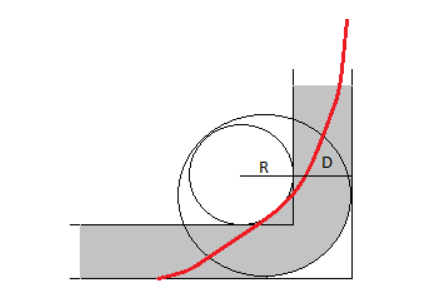
Jest to o tyle dogodne dla nas narzędzie iż dzięki takiemu przybliżeniu jesteśmy w stanie skorzystać z przekształconego wzoru i zamiast zmian kąta pod jakim pojazd się ustawia do trasy, które musiałyby bazować na dużych tablicach macierzowych za względu na pary punktów, korzystamy ze stałych promieni oraz danego przekształcenia: $\displaystyle s=\int \sqrt((r_{1}+(r_{2}-r_{1})/s_{1}*s)/(mu*g))ds$. Za pomocą tego wzoru zaimplementowanego do Julii sprawdzimy najkrótszą możliwą do pokonania trasę i będzie ona wartością bazową ze względu na jej stałość. 

In [46]:
##FUNKCJA PREZĘTUJĄCA ZAKRĘT
function integrand(s::Float64, r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64)
    u = r1 + (r2 - r1) / s1 * s
    sqrt(u/m*g)
end
a = 0.0
b = pi/2
max_order = 1000

1000

#### METODA PROSTOKĄTÓW

In [47]:
function integrate_rectangles(f, a, b, n)
    delta_x = (b - a) / n
    sum = 0.0

    for i in 0:n-1
        x = a + (i + 0.5) * delta_x
        sum += f(x)
    end
    result = delta_x * sum
    result
end

P = integrate_rectangles(x -> integrand(x, 10.0, 20.0, 1.0, 1.0, 10.0), a, b, max_order)

20.81292342039796

#### METODA TRAPEZÓW

In [48]:
function integrate_trapezoids(r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64, a::Float64, b::Float64, n::Int64)
    delta_s = (b - a) / n
    sum = 0.0
    s = a
    for i in 1:n-1
        u = r1 + (r2 - r1) / s1 * s
        sum += integrand(s, r1, r2, s1, m, g)
        s += delta_s
    end
    result = delta_s * ((integrand(a, r1, r2, s1, m, g) + integrand(b, r1, r2, s1, m, g)) / 2.0 + sum)
    result
end
T = integrate_trapezoids(10.0, 20.0, 1.0, 1.0, 10.0, a, b, max_order)

20.803452817123272

#### METODA SIMPSONA

In [49]:
function integrate_simpson(f, a, b, n)
    delta_x = (b - a) / n
    sum = f(a) + f(b)
    for i in 1:n-1
        x = a + i * delta_x
        if iseven(i)
            sum += 2 * f(x)
        else
            sum += 4 * f(x)
        end
    end
    result = delta_x / 3 * sum
    result
end

S = integrate_simpson(x -> integrand(x, 10.0, 20.0, 1.0, 1.0, 10.0), a, b, max_order)

20.812923226956855

#### PRÓBA KONTROLNA (ZA POMOCĄ PAKIETU WBUDOWANEGO QUADGK)

In [50]:
function integrate(r1::Float64, r2::Float64, s1::Float64, m::Float64, g::Float64, a::Float64, b::Float64)
    f(s) = integrand(s, r1, r2, s1, m, g)
    Q, err=quadgk(f, a, b)
    Q, err
end
W = (integrate(10.0, 20.0, 1.0, 1.0, 10.0, a, b))

(20.812923226956958, 2.063025306142663e-10)

#### ZESTAWIENIE TABELARYCZNE OBLICZEŃ DOTYCZĄCYCH DROGI ZE STAŁEGO WZORU (PORÓWNANIE METOD)

In [51]:
tabela = DataFrame(PROSTOKĄTÓW = P, TRAPEZÓW = T, SIMPSONA = S, WBUDOWANA = W[1])
tabela

1×4 DataFrame
 Row │ PROSTOKĄTÓW  TRAPEZÓW  SIMPSONA  WBUDOWANA 
     │ Float64      Float64   Float64   Float64   
─────┼────────────────────────────────────────────
   1 │     20.8129   20.8035   20.8129    20.8129

### OBLICZANIE DŁUGOŚCI WYGENEROWANYCH TRAS

#### FUNKCJA RIEMANNA

In [55]:
function riemann(f, a::Real, b::Real, n::Int; method="right")
  if method == "right"
     meth = (f,l,r) -> f(r) * (r-l)
  elseif method == "left"
     meth= (f,l,r) -> f(l) * (r-l)
  elseif method == "trapezoid"
     meth = (f,l,r) -> (1/2) * (f(l) + f(r)) * (r-l)
  elseif method == "simpsons"
     meth = (f,l,r) -> (1/6) * (f(l) + 4*(f((l+r)/2)) + f(r)) * (r-l)
  end

  xs = range(a, b, length=n+1)
  lrs = zip(Iterators.take(xs, n), Iterators.rest(xs, 1))
  sum(meth(f, l, r) for (l,r) in lrs)
end

riemann (generic function with 1 method)

#### I SPOSÓB

Pierwszy sposób jaki uwzględnimy w naszym projekcie będzie bazował na wzorze: . Zawarty jest on w pętli kodu, gdzie za pomocą ... obliczamy kąt .... Wszystkie wartości z tych obliczeń zostają dodane do tablicy dl dzięki czmu mamy zestawienie poszczególnych długości.

In [52]:
dl

692-element Vector{Any}:
 23.363418621369828
 24.630741242920234
 22.25342559097394
 23.60630826360763
 24.053224202776878
 24.223962067318336
 25.05930709860528
 24.346325347360857
 23.80281524741288
 25.086690966146076
 25.4611433559984
 20.744340126441386
 26.187408686620497
  ⋮
 24.987419140347193
 25.433628009275044
 25.184046935408226
 24.538170197034542
 23.410966897773474
 24.781977653437472
 25.22817117808855
 25.3978467226256
 25.519191955856193
 24.978542496376946
 25.269941127077146
 24.13255610902713

#### II SPOSÓB

In [65]:
suma_kwadratow_left = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="left")
    push!(suma_kwadratow_left, dlugosc_luku)
end
# suma_kwadratow_left

suma_kwadratow_right = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="right")
    push!(suma_kwadratow_right, dlugosc_luku)
end
# suma_kwadratow_right

suma_kwadratow_trapezoid = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="trapezoid")
    push!(suma_kwadratow_trapezoid, dlugosc_luku)
end
# suma_kwadratow_trapezoid

suma_kwadratow_simpsons = []
for s in 1:length(r)
    dlugosc_luku = riemann(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s], 100, method="simpsons")
    push!(suma_kwadratow_simpsons, dlugosc_luku)
end
# suma_kwadratow_simpsons

suma_kwadratow_wbudowana = []
for s in 1:length(r)
    dlugosc_luku = quadgk(x -> sqrt((r[s]*cos(x))^2 + (r[s]*sin(x))^2), 0, al[s])[1]
    push!(suma_kwadratow_wbudowana, dlugosc_luku)
end
# suma_kwadratow_wbudowana

In [67]:
suma = DataFrame(RIGHT = suma_kwadratow_right, LEFT = suma_kwadratow_left, TRAPEZÓW = suma_kwadratow_trapezoid, SIMPSONA = suma_kwadratow_simpsons, WBUDOWANA = suma_kwadratow_wbudowana)
suma

692×5 DataFrame
 Row │ RIGHT    LEFT     TRAPEZÓW  SIMPSONA  WBUDOWANA 
     │ Any      Any      Any       Any       Any       
─────┼─────────────────────────────────────────────────
   1 │ 23.3634  23.3634  23.3634   23.3634   23.3634
   2 │ 24.6307  24.6307  24.6307   24.6307   24.6307
   3 │ 22.2534  22.2534  22.2534   22.2534   22.2534
   4 │ 23.6063  23.6063  23.6063   23.6063   23.6063
   5 │ 24.0532  24.0532  24.0532   24.0532   24.0532
   6 │ 24.224   24.224   24.224    24.224    24.224
   7 │ 25.0593  25.0593  25.0593   25.0593   25.0593
   8 │ 24.3463  24.3463  24.3463   24.3463   24.3463
   9 │ 23.8028  23.8028  23.8028   23.8028   23.8028
  10 │ 25.0867  25.0867  25.0867   25.0867   25.0867
  11 │ 25.4611  25.4611  25.4611   25.4611   25.4611
  ⋮  │    ⋮        ⋮        ⋮         ⋮          ⋮
 683 │ 25.184   25.184   25.184    25.184    25.184
 684 │ 24.5382  24.5382  24.5382   24.5382   24.5382
 685 │ 23.411   23.411   23.411    23.411    23.411
 686 │ 24.782   24.782   24.782    24.782    24.782
 687 │ 25.2282  25.2282  25.2282   25.2282   25.2282
 688 │ 25.3978  25.3978  25.3978   25.3978   25.3978
 689 │ 25.5192  25.5192  25.5192   25.5192   25.5192
 690 │ 24.9785  24.9785  24.9785   24.9785   24.9785
 691 │ 25.2699  25.2699  25.2699   25.2699   25.2699
 692 │ 24.1326  24.1326  24.1326   24.1326   24.1326
                                       671 rows omitted

#### III SPOSÓB

Kolejną metodą dzięki której będziemy mogli porównać i tym samym zweryfikować wyniki będzie program który również będzie bazował na całce oznaczonej. Natomiast tym razem będzie to wzór znany w analizie jako wzór na długość krzywej, w naszym przypadku łuku. $\displaystyle L=\int \operatorname{dx}$ W widocznym wzorze wykorzystując wcześniej wygenerowane losowe trasy, oraz za pomocą zaimplementowanej przez nas funkcji „wielomian”, wyznaczamy wzory wielomianów które będą reprezentować trasę. Następnie wyznaczamy pochodną odpowiedniego wielomianu, tutaj domyślnie stopnia dwa, oraz obliczymy całkę oznaczoną z pierwiastka z sumy jedynki oraz kwadratu pochodnej funkcji. Odnosząc się do samej funkcji „wielomian” bazuje ona na wartościach pdpowiadających początkowi i końcowi trasy oraz wyznaczeniu prostej przechodzącej przez te punkty. Następnie program generuje łuk oraz wyznacza n punktów po których w dalszej części będzie przechodziła interacja aby z wykorzystaniem macierzy u nas w programie "A", wyznaczyć współczynniki wielomianu.

#### FUNKCJA WIELOMIAN

In [54]:
using Polynomials
function wielomian(r)
    # Wyznaczenie punktów końcowych łuku
    x1, y1 = r, 0
    x2, y2 = 0, r

    # Wyznaczenie równania prostej przechodzącej przez punkty (x1, y1) i (x2, y2)
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    # Wyznaczenie punktów przecięcia okręgu i prostej
    a = m^2 + 1
    b = 2 * m * b
    c = b^2 / 4 - r^2
    delta = sqrt(b^2 - 4 * a * c)
    x_1 = (-b + delta) / (2 * a)
    #x_2 = (-b - delta) / (2 * a)
    y_1 = m * x_1 + b
    #y_2 = m * x_2 + b

    # Wyznaczenie długości łuku między punktem (x1, y1) a punktem przecięcia (x_1, y_1)
    d = sqrt((x_1 - x1)^2 + (y_1 - y1)^2)

    # Wyznaczenie liczby punktów na łuku
    n = Int(round((d / r) * pi / 2))

    # Wyznaczenie punktów na łuku
    pary_punktow_luku = [(r * cos(t), r * sin(t)) for t in range(0, stop=pi/2, length=n)]

    # Wyznaczenie stopnia wielomianu
    stopien = div(n, 2)

    # Wyznaczenie współczynników wielomianu
    xs = [point[1] for point in pary_punktow_luku]
    ys = [point[2] for point in pary_punktow_luku]
    A = ones(n, stopien+1)
    for i=1:n
        for j=2:(stopien+1)
            A[i,j] = A[i,j-1] * xs[i]
        end
    end
    punkty = (A' * A) \ (A' * ys)
    return punkty
end

wielomian (generic function with 1 method)

In [56]:
wielomiany = []
for i in r
    miara = wielomian(i)
    push!(wielomiany, Polynomial([miara[1], miara[2], miara[3]]))  # Utwórz obiekt wielomianu za pomocą Polynomial
    n = 1000  # liczba punktów
end

wyniki_right = []
wyniki_left = []
wyniki_trapezoid = []
wyniki_simpsons = []

for i in wielomiany
    f_poly = Polynomial(i)  
    f_coeffs = coeffs(f_poly)  
    f_derivative = derivative(f_poly)  
    z(x) = sqrt(1 + f_derivative(x)^2)
    rr = riemann(z, 0, 15, 1000, method="right")
    rl = riemann(z, 0, 15, 1000, method="left")
    rt = riemann(z, 0, 15, 1000, method="trapezoid")
    rs = riemann(z, 0, 15, 1000, method="simpsons")
    push!(wyniki_right, rr)
    push!(wyniki_left, rl)
    push!(wyniki_trapezoid, rt)
    push!(wyniki_simpsons, rs)
end

In [57]:
dlugosc_krzywej = DataFrame(RIGHT = wyniki_right, LEFT = wyniki_left, TRAPEZÓW = wyniki_trapezoid, SIMPSONA = wyniki_simpsons)
dlugosc_krzywej

692×4 DataFrame
 Row │ RIGHT    LEFT     TRAPEZÓW  SIMPSONA 
     │ Any      Any      Any       Any      
─────┼──────────────────────────────────────
   1 │ 16.0929  16.0917  16.0923   16.0923
   2 │ 16.2195  16.2178  16.2187   16.2187
   3 │ 15.9748  15.9742  15.9745   15.9745
   4 │ 16.118   16.1167  16.1174   16.1174
   5 │ 16.1632  16.1618  16.1625   16.1625
   6 │ 16.1802  16.1786  16.1794   16.1794
   7 │ 16.2595  16.2576  16.2586   16.2586
   8 │ 16.1922  16.1906  16.1914   16.1914
   9 │ 16.1381  16.1367  16.1374   16.1374
  10 │ 16.262   16.2601  16.2611   16.2611
  11 │ 16.2955  16.2934  16.2945   16.2945
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 683 │ 15.8899  15.8898  15.8898   15.8898
 684 │ 15.8887  15.8886  15.8887   15.8887
 685 │ 15.8148  15.8151  15.8149   15.8149
 686 │ 15.9048  15.9046  15.9047   15.9047
 687 │ 15.9342  15.9338  15.934    15.934
 688 │ 15.9452  15.9448  15.945    15.945
 689 │ 15.9531  15.9526  15.9529   15.9529
 690 │ 15.9178  15.9175  15.9176   15.9176
 691 │ 15.8072  15.8076  15.8074   15.8074
 692 │ 15.7527  15.7534  15.7531   15.7531
                            671 rows omitted

#### TABELARYCZNE PORÓWNANIE WSZYSTKICH METOD (PRZY ZMIENNYCH DANYCH)

In [58]:
dlugosc_drogi = DataFrame(RIGHT = wyniki_right, LEFT = wyniki_left, TRAPEZÓW = wyniki_trapezoid, SIMPSONA = wyniki_simpsons, WYCINEK = dl, SUMA_KWADRATÓW = suma_kwadratow)
dlugosc_drogi

692×6 DataFrame
 Row │ RIGHT    LEFT     TRAPEZÓW  SIMPSONA  WYCINEK  SUMA_KWADRATÓW 
     │ Any      Any      Any       Any       Any      Any            
─────┼───────────────────────────────────────────────────────────────
   1 │ 16.0929  16.0917  16.0923   16.0923   23.3634  23.3634
   2 │ 16.2195  16.2178  16.2187   16.2187   24.6307  24.6307
   3 │ 15.9748  15.9742  15.9745   15.9745   22.2534  22.2534
   4 │ 16.118   16.1167  16.1174   16.1174   23.6063  23.6063
   5 │ 16.1632  16.1618  16.1625   16.1625   24.0532  24.0532
   6 │ 16.1802  16.1786  16.1794   16.1794   24.224   24.224
   7 │ 16.2595  16.2576  16.2586   16.2586   25.0593  25.0593
   8 │ 16.1922  16.1906  16.1914   16.1914   24.3463  24.3463
   9 │ 16.1381  16.1367  16.1374   16.1374   23.8028  23.8028
  10 │ 16.262   16.2601  16.2611   16.2611   25.0867  25.0867
  11 │ 16.2955  16.2934  16.2945   16.2945   25.4611  25.4611
  ⋮  │    ⋮        ⋮        ⋮         ⋮         ⋮           ⋮
 683 │ 15.8899  15.8898  15.8898   15.8898   25.184   25.184
 684 │ 15.8887  15.8886  15.8887   15.8887   24.5382  24.5382
 685 │ 15.8148  15.8151  15.8149   15.8149   23.411   23.411
 686 │ 15.9048  15.9046  15.9047   15.9047   24.782   24.782
 687 │ 15.9342  15.9338  15.934    15.934    25.2282  25.2282
 688 │ 15.9452  15.9448  15.945    15.945    25.3978  25.3978
 689 │ 15.9531  15.9526  15.9529   15.9529   25.5192  25.5192
 690 │ 15.9178  15.9175  15.9176   15.9176   24.9785  24.9785
 691 │ 15.8072  15.8076  15.8074   15.8074   25.2699  25.2699
 692 │ 15.7527  15.7534  15.7531   15.7531   24.1326  24.1326
                                                     671 rows omitted

## NAJKRÓTSZA TRASA NA WYKRESIE

In [59]:
plot(tab3, tab4, -pi, pi, aspectratio=1, linewidth=1, xlim=(0, ograniczenie_g),
     ylim=(0, ograniczenie_g), legend=false)
plot!(tab1, tab2, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)
plot!(tab3[argmin(dl)], tab4[argmin(dl)], -pi, pi, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)

## ANIMACJA TRASY

[ Info: Saved animation to C:\Users\Aleksandra\OneDrive\Documents\PROGRAMOWANIE\Julia\Projekt_Pakiety_Matematyczne\tmp.gif


Plots.AnimatedGif("C:\\Users\\Aleksandra\\OneDrive\\Documents\\PROGRAMOWANIE\\Julia\\Projekt_Pakiety_Matematyczne\\tmp.gif")
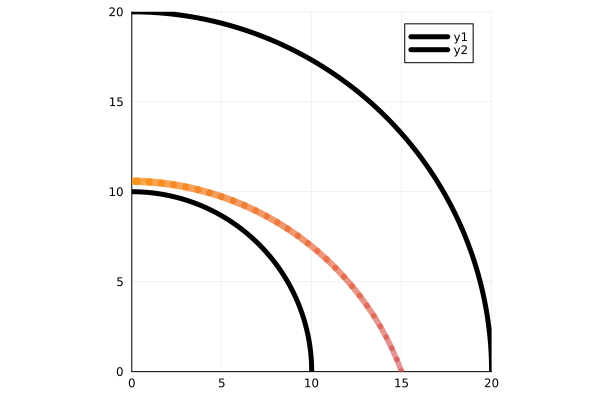

In [60]:
@userplot CirclePlot
@recipe function f(cp::CirclePlot)
    x, y, i = cp.args
    n = length(x)
    inds = circshift(1:n, 1 - i)
    linewidth --> range(0, 10, length = n)
    seriesalpha --> range(0, 1, length = n)
    aspect_ratio --> 1
    label --> false
    x[inds], y[inds]
end

function animacja(num)
    n = 150
    t = range(-pi, π, length = n)
    y6 = r[num]*sin.(t) .+ y[num]
    x6 = r[num]*cos.(t) .+ x3[num] 
    
    anim = @animate for i ∈ 1:n
        circleplot!(x6, y6, i)
    end
    
    @gif for i ∈ 1:n
        plot(tab1, tab2, 0, pi/2, aspectratio=1, linewidth=5, thickness_scaling=1, c=:black)
        circleplot!(x6, y6, i, line_z = 1:n, cbar = false, framestyle = :zerolines,  xlim=(0,20), ylim=(0, 20))
    end every 5
end

animacja(argmin(dl))